
# **Application Focused - Custom YOLOv3 Face Mask Detection System**

The main goal is to train a custom deep learning model to detect whether a person is or is not wearing a mask.

**YouTube video demo :**

https://www.youtube.com/watch?v=e_6B9EGZv80&t=13s

Using OpenCV for single thread and video acceleration using multithread

**Use Cases and Real-life applications meeting the csutomer requirements:**

**1. Airports:**

The Face Mask Detection System can be used at airports to detect travelers without masks. Face data of travelers can be captured in the system at the entrance. If a traveler is found to be without a face mask, the airport authorities can be notified via SMS so that they could take quick action. 

**2. Hospitals**

Using Face Mask Detection System, Hospitals can monitor if their staff is wearing masks during their shift or not. If any health worker is found without a mask, they will receive a notification with a reminder to wear a mask. Also, if quarantine people who are required to wear a mask, the system can keep an eye and detect if the mask is present or not and send notification automatically or report to the authorities.

**3. Offices**

The Face Mask Detection System can be used at office premises to detect if employees are maintaining safety standards at work. It monitors employees without masks and sends them a reminder to wear a mask. The reports can be downloaded or sent an email at the end of the day to capture people who are not complying with the regulations or the requirements.

**Application Features:**

**1. Real time Face Mask Detection- OpenCV Single Threading**

**2. Real time text alert - Notification Interface**
If the face mask detector application identifies a user that he/she was not wearing a mask, AI alerts are sent to the registered phone number of the administrator. It allows the application to run automatically and enforces the wearing of the mask.

**3. Real time Face Mask Detection- OpenCV Multi Threading**

**4. Comparison of video inference pipeline for single and multithread**




**Steps:**

This notebook explains training a custom object detection model using the YoloV3.

The notebook is split into the following parts:
* Check System Requirements
* Installation
* Download pretrained YOLOv3 weights
* Run Detections with Darknet and YOLOv3
* Training a Custom YOLOv3 Object Detector
  * Prepare data using LabelImg
  * Configure the obj.names with the objects to detect
  * Configure obj.data file with the number of classes and backup location
  * Generating train.txt and test.txt
  * Configuring custom .cfg file for Custom Training
  * Download pre-trained weights for the convolutional layers
  * Train the Custom Object Detector
* Run the Custom Object Detector
  * Test trained model on test images
  * Test trained model on video
  * Test trained model on video using Youtube link
* Video Output Inference
* Evaluation of speed of video inference pipeline
* Real Time Text Alert System
* Future Enhancements
* References

## **Architecture/Design of the Face Mask Detector Model**

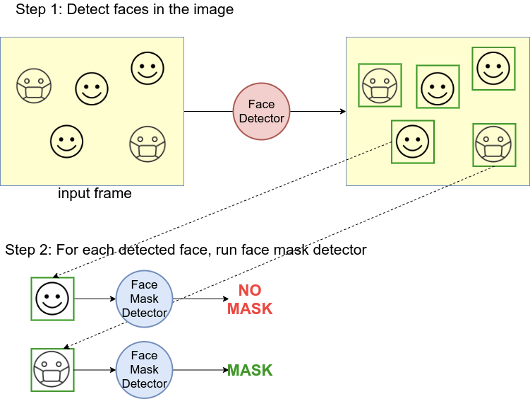

## **Check System Requirements**

In [ ]:
import tensorflow as tf
print("GPU Available: ", tf.test.is_gpu_available())

print("Tensorflow Version: ", tf.__version__)
print("Keras Version: ", tf.keras.__version__)

#check GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
Tensorflow Version:  2.3.0
Keras Version:  2.4.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!nvidia-smi

Sat Dec  5 18:28:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    30W / 250W |    359MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **Installation- Clone and build darknet**

In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 14562, done.
remote: Total 14562 (delta 0), reused 0 (delta 0), pack-reused 14562
Receiving objects: 100% (14562/14562), 13.19 MiB | 22.44 MiB/s, done.
Resolving deltas: 100% (9910/9910), done.


In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

/content/tensorflow-yolo-v3/darknet


In [ ]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [ ]:
# make darknet (build)
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:926:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1127:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

In [ ]:
#Functions required
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def imShow(path):
    '''
    Function to Display an image

    '''
    
    image = cv2.imread(path)
    height, width = image.shape[:2]
    resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

    fig = plt.gcf()
    fig.set_size_inches(18, 10)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    plt.show()


def download(path):
    '''
    Function to download files from colab

    '''
    from google.colab import files
    files.download(path)

In [ ]:
!pwd

/content/darknet


## **Download pretrained YOLOv3 weights**

YOLOv3 has been trained already on the coco dataset which has 80 classes that it can predict. We will grab these pretrained weights so that we can run YOLOv3 on these pretrained classes and get detections.

In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2020-12-03 18:43:58--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M   421KB/s    in 8m 37s  

2020-12-03 18:52:36 (469 KB/s) - ‘yolov3.weights’ saved [248007048/248007048]



## **Run Detections with Darknet and YOLOv3**

In [ ]:
!./darknet detect cfg/yolov3.cfg yolov3.weights /content/y.jpg

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x

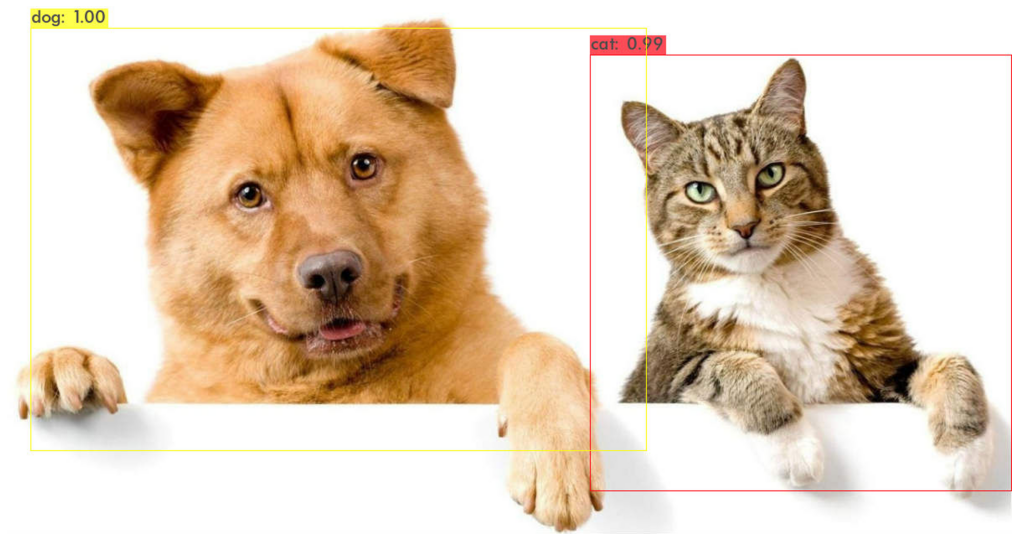

In [ ]:
imShow('predictions.jpg')

## **Training a Custom YOLOv3 Object Detector**

### **Prepare data**
**Gathering and Labeling a Custom Dataset using LabelImg**

**Collect data and create own custom dataset**

To train a robust model, we need a lot of pictures that vary greatly from each other. We can either take the pictures ourself or we can download them from the internet.

After collecting the images we need to label them. For this I used LabelImg - an free, open source graphical image annotation tool.

After labeling the images, split the data into a training and testing part and convert the xml label files to text.

I uploaded my Object Detection dataset on Kaggle. The below four cells are used to download and extract the data-set.

In [ ]:
# Install Kaggle API
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 7.0MB/s 
     |████████████████████████████████| 5.3MB 12.8MB/s 
     |████████████████████████████████| 112kB 76.1MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 133kB 72.5MB/s 


In [ ]:
# only for google colab
import os
os.environ['KAGGLE_USERNAME'] = "geethupadachery" 
os.environ['KAGGLE_KEY'] = "***"

In [ ]:
! kaggle datasets download -d geethupadachery/face-mask-detection --unzip

 69% 49.0M/71.0M [00:02<00:02, 10.5MB/s]
100% 71.0M/71.0M [00:02<00:00, 27.4MB/s]


In [ ]:
! kaggle datasets download -d geethupadachery/object-detection-dataset --unzip

 99% 5.00M/5.04M [00:01<00:00, 4.80MB/s]
100% 5.04M/5.04M [00:01<00:00, 4.73MB/s]


In [ ]:
!mv "/content/Face Mask Detection" face-detection-dataset

In [ ]:
!mv "Object Detection Dataset" object-detection-dataset


In [ ]:
#%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/Colab\ Notebooks/ /mydrive
!ls /mydrive

ln: failed to create symbolic link '/mydrive/Colab Notebooks': File exists
'Colab Notebooks'
 ConvertWeightsToPb.ipynb
'Copy of Making the Most of your Colab Subscription'
 Face_Detection.ipynb
'FaceVehiclePerson of Final of Tensorflow 2 Object Detection: Train model.ipynb'
'FINAL Homework 2 -FaceVehiclePerson Detection'
'final project'
'Geethu- Custom Object Detection-Homework 2.ipynb'
 homework2
 homework2-car-detection
 LiarPlusFinal.ipynb
'Testing of FaceVehiclePerson.ipynb'
'Traffic Light Custom Training.ipynb'
 yolov3


In [ ]:
# All the necessary files stored in my drive
!ls /mydrive/yolov3

backup		   obj	     obj.names	 yolov3_custom.cfg
darknet53.conv.74  obj.data  yolo.ipynb


In [ ]:
# # this copies the zip file from my drive to the root directory of colab
# !cp /content/gdrive/My\ Drive/Colab\ Notebooks/yolov3/obj.zip ../

In [ ]:
!ls

3rdparty		 darknet53.conv.74.1	 net_cam_v3.sh
backup			 DarknetConfig.cmake.in  net_cam_v4.sh
build			 darknet_images.py	 obj
build.ps1		 darknet.py		 predictions.jpg
build.sh		 darknet_video.py	 README.md
cfg			 data			 results
chart.png		 image_yolov3.sh	 scripts
chart_yolov3_custom.png  image_yolov4.sh	 src
cmake			 include		 video_yolov3.sh
CMakeLists.txt		 json_mjpeg_streams.sh	 video_yolov4.sh
darknet			 LICENSE		 yolov3.weights
darknet53.conv.74	 Makefile


In [ ]:
# # this extracts the zip file from the root to the darknet/data directory
# !unzip ../obj.zip -d data/obj

### **Configure the obj.names with the objects to detect**

In [ ]:
! wget https://raw.githubusercontent.com/geethupadachery/MaskDetection/main/obj.names?token=AM7U3IDZGAF72DOWZ3SH3LS72UWCS

--2020-12-05 20:47:16--  https://raw.githubusercontent.com/geethupadachery/MaskDetection/main/obj.names?token=AM7U3IDZGAF72DOWZ3SH3LS72UWCS
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18 [text/plain]
Saving to: ‘obj.names?token=AM7U3IDZGAF72DOWZ3SH3LS72UWCS’

obj.names?token=AM7 100%[===================>]      18  --.-KB/s    in 0s      

2020-12-05 20:47:16 (975 KB/s) - ‘obj.names?token=AM7U3IDZGAF72DOWZ3SH3LS72UWCS’ saved [18/18]



In [ ]:
!cat obj.names

Mask
Without_mask


### **Configure obj.data file with the number of classes and backup location**. 

This backup path is where we will save the weights to of our model throughout training. 

In [ ]:
! wget https://raw.githubusercontent.com/geethupadachery/MaskDetection/main/obj.data?token=AM7U3IAACVFXZBK35T5353S72UZAA

--2020-12-05 21:11:51--  https://raw.githubusercontent.com/geethupadachery/MaskDetection/main/obj.data?token=AM7U3IAACVFXZBK35T5353S72UZAA
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111 [text/plain]
Saving to: ‘obj.data?token=AM7U3IAACVFXZBK35T5353S72UZAA’

obj.data?token=AM7U 100%[===================>]     111  --.-KB/s    in 0s      

2020-12-05 21:11:52 (7.95 MB/s) - ‘obj.data?token=AM7U3IAACVFXZBK35T5353S72UZAA’ saved [111/111]



In [ ]:
!cat obj.data

classes = 2
train = data/train.txt
valid = data/test.txt
names = data/obj.names
backup= /mydrive/yolov3/backup/

### **Generating train.txt and test.txt**

The configuration file needed before we can begin to train our custom detector is the train.txt and test.txt file which hold the relative paths to all our training images.

In [ ]:
#Creating two .txt files for train and validation containing the names of images respectively
import glob
import os

current_dir = '/mydrive/yolov3/obj'
#Percentage of images to be used for the valid set
percentage_test = 10;

# Create train.txt and valid.txt
file_train = open('data/train.txt', 'w')  
file_test = open('data/test.txt', 'w')

# for file in glob.iglob(os.path.join(current_dir, '*.jpg')):
#   file_test.write(current_dir + "/" + title + '.jpg' + "\n")
#   file_train.write(current_dir + "/" + title + '.jpg' + "\n")

# Populate train.txt and valid.txt

counter = 1  
index_test = round(100 / percentage_test)  
for file in glob.iglob(os.path.join(current_dir, '*.jpg')):  
  title, ext = os.path.splitext(os.path.basename(file))
  if counter == index_test:
    file_test.write(current_dir + "/" + title + '.jpg' + "\n")
    counter = 1
  else:
    file_train.write(current_dir + "/" + title + '.jpg' + "\n")
    counter = counter + 1

### **Configuring custom .cfg file for Custom Training**

This step involves properly configuring custom .cfg file, obj.data, obj.names and train.txt file.Now we have to edit the .cfg to fit the needs based on the custom mask detector.

In [ ]:
!wget https://raw.githubusercontent.com/geethupadachery/MaskDetection/main/yolov3_custom.cfg?token=AM7U3IF4P6WM6UILO4XRDCS72U676

--2020-12-05 22:03:02--  https://raw.githubusercontent.com/geethupadachery/MaskDetection/main/yolov3_custom.cfg?token=AM7U3IF4P6WM6UILO4XRDCS72U676
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8329 (8.1K) [text/plain]
Saving to: ‘yolov3_custom.cfg?token=AM7U3IF4P6WM6UILO4XRDCS72U676’

yolov3_custom.cfg?t 100%[===================>]   8.13K  --.-KB/s    in 0s      

2020-12-05 22:03:02 (93.6 MB/s) - ‘yolov3_custom.cfg?token=AM7U3IF4P6WM6UILO4XRDCS72U676’ saved [8329/8329]



In [ ]:
!cat yolov3_custom.cfg\?token\=AM7U3IF4P6WM6UILO4XRDCS72U676

[net]
# Testing
# batch=1
# subdivisions=1
# Training
batch=32
subdivisions=8
width=608
height=608
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 4000
policy=steps
steps=3200,3400
scales=.1,.1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

# Downsample

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=32
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

# Downsample

[convolutional]
batch_normalize=1
filters=128
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutional]
batc

In [ ]:
# this copies the configuration file for yolo customized for the dataset from my drive to the darknet directory
!cp /mydrive/yolov3/yolov3_custom.cfg ./cfg

In [ ]:
# this copies the names and data files for yolo customized for the dataset from my drive to the darknet directory
!cp /mydrive/yolov3/obj.names ./data
!cp /mydrive/yolov3/obj.data  ./data

### **Download pre-trained weights for the convolutional layers**

This step downloads the weights for the convolutional layers of the YOLOv3 network. By using these weights it helps our custom object detector to be way more accurate and not have to train as long.

In [ ]:
# download pretrained convolutional layer weights such that the CONV layers don't initialize from scratch
!wget http://pjreddie.com/media/files/darknet53.conv.74

URL transformed to HTTPS due to an HSTS policy
--2020-12-03 19:59:48--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74.1’

darknet53.conv.74.1 100%[===================>] 154.96M   371KB/s    in 6m 4s   

2020-12-03 20:05:54 (436 KB/s) - ‘darknet53.conv.74.1’ saved [162482580/162482580]



In [ ]:
#this copies the weights to my drive
!cp darknet53.conv.74 /mydrive/yolov3/darknet53.conv.74

### **Train the Custom Object Detector**

Finally, train the custom object detector.

We will have a log line per epoch and each each iteration we can monitor how our training is going.

In the backup folder Darknet saves a few weights files:

files that end in 1000,2000 etc are weights saved every 1000 batches
best weights file are the weights that gave best results during training
final weights file contains the final weights at the end of the training

In [ ]:
# The below command trains on the dataset
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg darknet53.conv.74 -dont_show

Streaming output truncated to the last 5000 lines.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, total_loss = 0.000004 
 total_bbox = 183281, rewritten_bbox = 0.106940 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.856531), count: 4, total_loss = 0.124652 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.000000), count: 1, total_loss = 0.000000 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, total_loss = 0.000001 
 total_bbox = 183285, rewritten_bbox = 0.106937 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.871164), count: 4, total_loss = 0.074039 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.000000), count: 1, total_loss = 0.000001 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1,

We can observe a chart of how our model did throughout the training process by running the below command. It shows a chart of our average loss vs. iterations. For our model to be 'accurate' the loss should be ideally under 2.

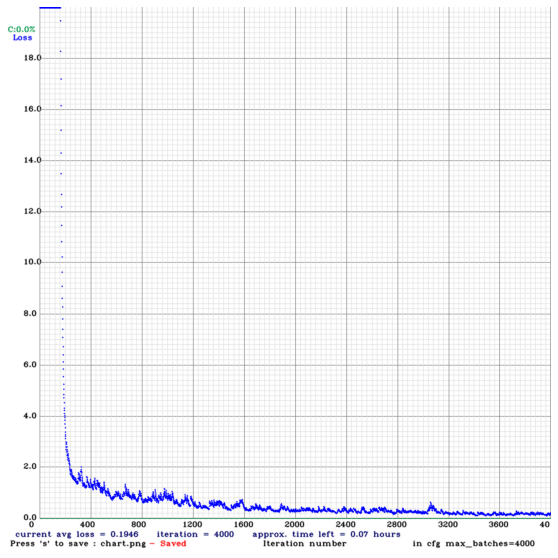

In [ ]:
imShow('chart.png')

## **Run the Custom Object Detector**

We have a custom object detector which detects mask.

### **Test trained model on test images**

In [ ]:
# this command is used to test on a particular image
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /mydrive/yolov3/backup/yolov3_custom_last.weights /content/Test_Image_1.jpeg -thresh 0.3 -ext_output

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   3 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   5 conv    128       3 x 3/ 2    304 x 304 x  64 ->  152 x 152 x 128 3.407 BF
   6 conv     64       1 x 1/ 1    152 x 152 x 128 ->  152 x 152 x  64 0.379 BF
   7 conv    128       3 x 3/ 1    152 x 152 x  64 ->  152 x 152 x 128 3.407 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 152 x 152 x

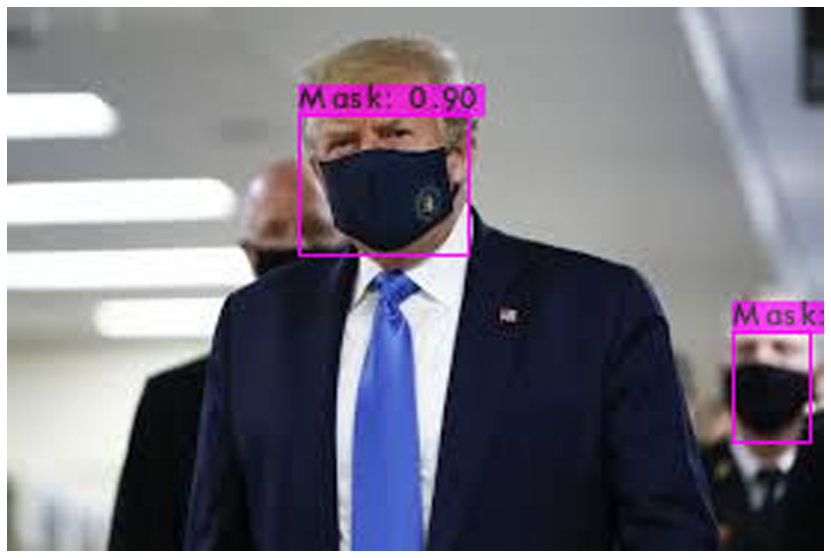

In [ ]:
imShow('predictions.jpg')

In [ ]:
# this command is used to test on a particular image
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /mydrive/yolov3/backup/yolov3_custom_last.weights /content/Test_Image_2.jpeg -thresh 0.3 -ext_output

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   3 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   5 conv    128       3 x 3/ 2    304 x 304 x  64 ->  152 x 152 x 128 3.407 BF
   6 conv     64       1 x 1/ 1    152 x 152 x 128 ->  152 x 152 x  64 0.379 BF
   7 conv    128       3 x 3/ 1    152 x 152 x  64 ->  152 x 152 x 128 3.407 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 152 x 152 x

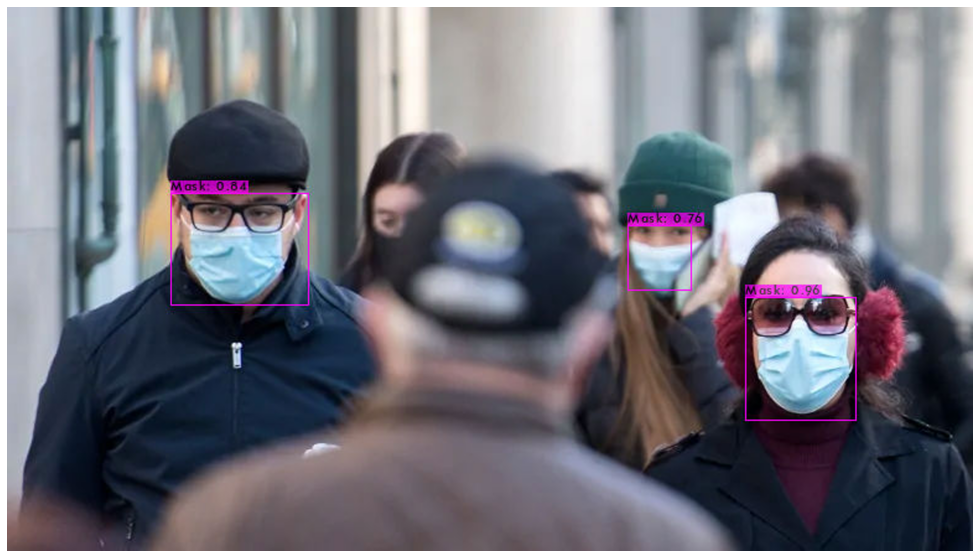

In [ ]:
imShow('predictions.jpg')

In [ ]:
#The following is used to re-run from the saved weights 
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg /mydrive/yolov3/backup/yolov3_custom_last.weights -dont_show -clear 

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
yolov3_custom
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 4, batch = 32, time_steps = 1, train = 1 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   3 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   5 conv    128       3 x 3/ 2    304 x 304 x  64 ->  152 x 152 x 128 3.407 BF
   6 conv     64       1 x 1/ 1    152 x 152 x 128 ->  152 x 152 x  64 0.379 BF
   7 conv    128       3 x 3/ 1    152 x 152 x  64 ->  152 x 152 x 128 3.407 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outpu

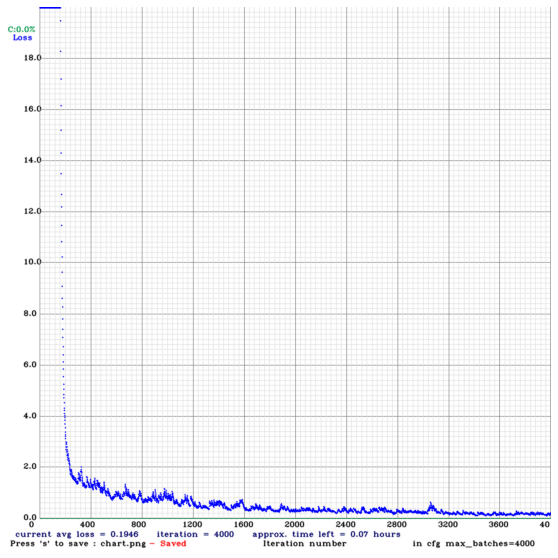

In [ ]:
imShow('chart.png')

In [ ]:
# this command is used to test on a particular image
!./darknet detector test /content/obj.data /content/yolov3_custom.cfg /content/yolov3_face_mask.weights /content/test1.jpg -thresh 0.3 -ext_output 

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   3 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   5 conv    128       3 x 3/ 2    304 x 304 x  64 ->  152 x 152 x 128 3.407 BF
   6 conv     64       1 x 1/ 1    152 x 152 x 128 ->  152 x 152 x  64 0.379 BF
   7 conv    128       3 x 3/ 1    152 x 152 x  64 ->  152 x 152 x 128 3.407 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 152 x 152 x

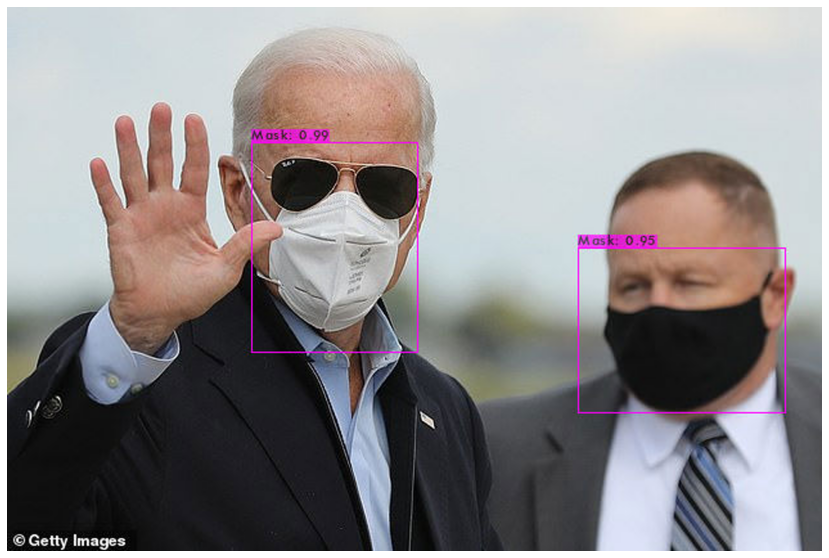

In [ ]:
imShow('predictions.jpg')

### **Test trained model on video**

In [ ]:
# run the custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
!./darknet detector demo data/obj.data cfg/yolov3_custom.cfg /mydrive/yolov3/backup/yolov3_custom_last.weights -dont_show /content/test_video.mp4 i 0 -out_filename out.mp4

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
Demo
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   3 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   5 conv    128       3 x 3/ 2    304 x 304 x  64 ->  152 x 152 x 128 3.407 BF
   6 conv     64       1 x 1/ 1    152 x 152 x 128 ->  152 x 152 x  64 0.379 BF
   7 conv    128       3 x 3/ 1    152 x 152 x  64 ->  152 x 152 x 128 3.407 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 152 x 

### **Inference from Youtube video**

In [ ]:
!pip install pytube3

In [ ]:
!python -m pip install git+https://github.com/nficano/pytube

  Cloning https://github.com/nficano/pytube to /tmp/pip-req-build-8lf59pbm
  Running command git clone -q https://github.com/nficano/pytube /tmp/pip-req-build-8lf59pbm
  Created wheel for pytube: filename=pytube-10.0.0-cp36-none-any.whl size=42672 sha256=c9bd18f7e71bb5e3414f59214a8a17c420614d7f65e27aaa66d2f720234f0022
  Stored in directory: /tmp/pip-ephem-wheel-cache-3o2iv6um/wheels/44/da/40/3b5e03abe33a91895343814fb44b309512375408f4a909555b
Successfully built pytube


In [ ]:
import pytube
video_url = 'https://www.youtube.com/watch?v=F6rQj0FhT1A'#'https://www.youtube.com/watch?v=gY8E8ILFkzo'
youtube = pytube.YouTube(video_url)
video = youtube.streams.first()

In [ ]:
!pwd
!mkdir videos

/content/darknet


In [ ]:
video.download('videos/')

'/content/darknet/videos/Black Friday Crowds Reduced At Glendale Galleria Amid Pandemic Restrictions.mp4'

In [ ]:
!mv ./videos/*.mp4 video1.mp4

In [ ]:
import os
import pathlib
import cv2
import time
#!apt install python3-opencv
print(cv2.__version__)

4.1.2


In [ ]:
!pip install --upgrade imutils

Requirement already up-to-date: imutils in /usr/local/lib/python3.6/dist-packages (0.5.3)


In [ ]:
from imutils.video import FPS
import imutils

In [ ]:
!ffmpeg -ss 00:00:00 -i video1.mp4 -t 00:00:59 -c:v copy video-clip1.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [ ]:
import cv2
video_path='./video-clip1.mp4'
cap = cv2.VideoCapture(video_path)
print(cap.get(cv2.CAP_PROP_FPS))
# We convert the resolutions from float to integer.
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
print(frame_width)
print(frame_height)

29.97002997002997
640
360


In [ ]:
# run the custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
!./darknet detector demo /content/obj.data /content/yolov3_custom.cfg /mydrive/yolov3/backup/yolov3_custom_last.weights -dont_show /content/video-clip1.mp4 i 0 -out_filename out2.mp4

Streaming output truncated to the last 5000 lines.
Mask: 57% 
Mask: 32% 

FPS:62.6 	 AVG_FPS:63.1

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 96% 
Mask: 93% 
Mask: 63% 
Mask: 52% 
Mask: 34% 

FPS:62.8 	 AVG_FPS:63.1

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 97% 
Mask: 92% 
Mask: 71% 
Mask: 68% 
Mask: 34% 

FPS:62.8 	 AVG_FPS:63.1

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 98% 
Mask: 91% 
Mask: 80% 
Mask: 66% 
Mask: 38% 

FPS:63.0 	 AVG_FPS:63.1

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 98% 
Mask: 94% 
Mask: 87% 
Mask: 81% 
Mask: 39% 

FPS:63.2 	 AVG_FPS:63.1

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 98% 
Mask: 93% 
Mask: 87% 
Mask: 87% 
Mask: 37% 

FPS:63.2 	 AVG_FPS:63.1

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 99% 
Mask: 91% 
Mask: 91% 
Mask: 84% 
Mask: 29% 

FPS:63.1 	 AVG_FPS:63.1

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 99% 
Mask: 91% 
Mask: 91% 
Mask: 81% 
Mask: 27% 

FPS:63.2 	 AVG_FPS:63.1

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 99% 
Mask: 88% 
Mask: 88% 
Mask:

**Download the output video with the bounding box** 

In [ ]:
from google.colab import files
files.download('out2.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# run the custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
!./darknet detector demo /content/obj.data /content/yolov3_custom.cfg /mydrive/yolov3/backup/yolov3_custom_last.weights -dont_show /content/test_video.mp4 i 0 -out_filename test_output.mp4

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
Demo
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   3 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   5 conv    128       3 x 3/ 2    304 x 304 x  64 ->  152 x 152 x 128 3.407 BF
   6 conv     64       1 x 1/ 1    152 x 152 x 128 ->  152 x 152 x  64 0.379 BF
   7 conv    128       3 x 3/ 1    152 x 152 x  64 ->  152 x 152 x 128 3.407 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 152 x 

In [ ]:
from google.colab import files
files.download('test_output.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##**Video Output Inference**

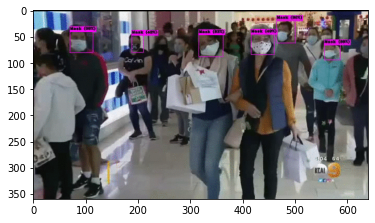

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("/content/out3.gif")
plt.imshow(img)

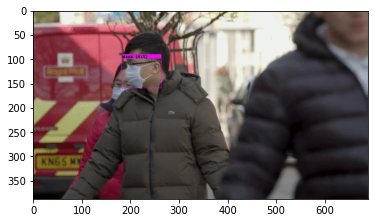

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("/content/test_output.gif")
plt.imshow(img)

##**Evaluation of the speed of video inference pipeline**

Used Multithreading with OpenCV-Python to improve video processing performance.

This is achieved by putting calls to cv2.VideoCapture.read() and cv2.imshow() in their own dedicated threads.

In a single-threaded video processing application, we might have the main thread execute the following tasks in an infinitely looping while loop: 

* get a frame from the webcam or video file with cv2.VideoCapture.read()

* process the frame as we need

* display the processed frame on the screen with a call to cv2.imshow(). 

By moving the reading and display operations to other threads, each iteration of the while loop should take less time to execute. Consequently, we’ll define our performance metric as the number of iterations of the while loop in the main thread executed per second.

**Comparison of video inference pipeline for single and multithread**

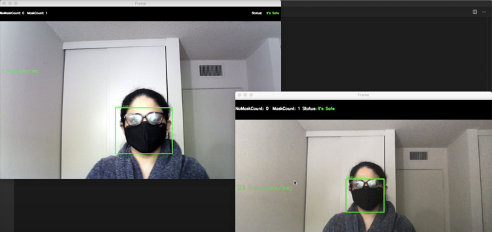

**Real time video inference using Single thread**
The number of frames per second is 1 for single thread video inference pipleline.

**Real time video inference using Multithread**
The number of frames per second is 23 for multithread video inference pipeline. This is significantly higher than the single thread video inference using OpenCV.

## **Real Time Text Alert System**
**SMS Alert System**: 

It monitors the mask, no-mask counts and has 3 status :
* Safe : When all people are with mask.
* Warning : When atleast 1 person is without mask.
* No Mask : ( + SMS Alert ) When some ratio of people are without mask.

It detects human faces with 𝐦𝐚𝐬𝐤 𝐨𝐫 𝐧𝐨-𝐦𝐚𝐬𝐤 even in crowd in real time with live count status and notifies user (officer) if danger.

* Send an SMS with Twilio's API
* To send a new outgoing message from a Twilio phone number to an outside number, make an HTTP POST to your account's Message resource.
* The Body parameter includes the full text of the message you want to send, limited to 1600 characters.

Real time text alerts are send to the registered users showing the maks and nomask count as well as the time of detection for real time tracking

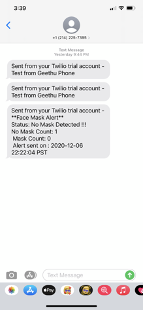



## **Performance Enhancing Strategies**

In order to smooth out the results and to reduce the false alarm of the mask detection I am using two logic:

* If the face is not found in the frame, the mask detector won't be applied.

* I have set a configurable threshold value to send alert based on the NoMask count.For this application purpose, I have put the threshold value for NoMask count as 1.This can be increased according to the user requirements.

##**Future Enhancements:**
**Real-time Monitoring Dashboard**

A user-friendly website allows the user to see who was not wearing a mask and see the photo or the video captured by the camera. User can also generate reports to download and integrate with any other third-party integration.



## **Working Code:**

**Google drive link with all the code and the inference output**

https://drive.google.com/drive/folders/1cafU7HwguctTwAVTHGQSE1ZEdVh5L_y_?usp=sharing

**Github link:**
https://github.com/geethupadachery/MaskDetection.git


## **References:**

* https://pjreddie.com/darknet/yolo/

* https://arxiv.org/pdf/2003.09093.pdf

* https://arxiv.org/abs/1804.02767

* https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/

* https://medium.com/@ODSC/overview-of-the-yolo-object-detection-algorithm-7b52a745d3e0

* https://www.analyticsvidhya.com/blog/2018/12/practical-guide-object-detection-yolo-framewor-python/